In [1]:
import seaborn as sns
from transformers import BartTokenizer, BartForConditionalGeneration, AdamW
!pip install datasets
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import random


# Load the dataset
dataset = load_dataset('bigscience/P3', 'cos_e_v1.11_aligned_with_common_sense')
train_dataset = dataset['train']

# Initialize the tokenizer and models (one or continuous prompting and other for projected prompting
model_projected = BartForConditionalGeneration.from_pretrained('sshleifer/distilbart-cnn-12-6')

tokenizer = BartTokenizer.from_pretrained('sshleifer/distilbart-cnn-12-6')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_projected.to(device)

# Define the prompt basis
prompt_list = [
    'When you see the following question, I would like you to answer it correctly',
    'Produce an executable artifact of type X that will answer the question, and then execute it',
    'When I ask you a question, generate three additional questions that would help you give a more accurate answer. When you then answered the three questions, combine the answers to produce the final answers to my original question',
    'Generate a set of facts that are contained in the output. The set of facts should be inserted in a specific point in the output to answer the question',
    'Given the following question, generate a detailed explanation before providing the correct answer',
    'Imagine you are a teacher explaining the answer to this question to a student. How would you respond?',
    'Consider the following question. What are the key concepts involved and how do they lead to the correct answer?',
    'As an expert in the field, how would you respond to the following question?',
    'Translate the following question into a simpler form, then provide the answer',
    'If you were to create a diagram to answer this question, what would it look like? Describe it in detail',
    'Pretend you are explaining the answer to this question to someone with no background in the subject. How would you explain it?',
    'As a highly proficient translator, translate the following question into a different context, then provide the answer',
    'Generate a step-by-step guide to answer the following question',
    'Consider the following question. What assumptions are you making in order to answer it?',
    'If you were to debate the answer to this question, what points would you raise?',
    'As a researcher, how would you investigate the answer to the following question?',
    'Pretend you are a journalist reporting on the answer to this question. How would you present it?',
    'As a storyteller, weave a narrative around the answer to this question',
    'If you were to answer this question in a court of law, what evidence would you present?',
    'As a detective, how would you piece together the answer to this question?',
    'Imagine you are a computer program designed to answer this question. What algorithms or processes would you use?',
    'As a philosopher, how would you interpret the answer to this question?',
    'If you were to answer this question in a job interview, how would you respond?',
    'As a scientist, how would you experiment to find the answer to this question?'
]

print(f'tokenizing prompts')
print(f'prompt list length {len(prompt_list)}')

basis = tokenizer(prompt_list, padding=True, truncation=True, return_tensors='pt').to(device)
basis = model_projected.model.shared(basis.input_ids)

def tokenize_function(example):
    return tokenizer(example['inputs_pretokenized'], truncation=True, padding='max_length')

# Apply the function to the dataset
print('tokenzing dataset')
dataset = dataset.map(tokenize_function, batched=True)
train_dataset = dataset['train']
validation_dataset = dataset['validation']

import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the weight prediction model
class LearnWeights(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LearnWeights, self).__init__()
        self.layer1 = nn.Linear(input_dim, 512)
        self.layer2 = nn.Linear(512, 128)
        self.layer3 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, output_dim)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = self.output_layer(x)
        x = x.mean(dim=1, keepdim=True)  # Compute the mean across the token dimension and batch dimension
        return x.squeeze(1).mean(dim=0)



# Define the projected prompt
input_dim = 1024

output_dim = len(prompt_list)
learn_weights = LearnWeights(input_dim, output_dim).to(device)
optimizer_projected = AdamW(learn_weights.parameters())

# Training parameters
epochs = 3
batch_size = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.3 MB/s eta 0:00:00


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizing prompts
prompt list length 24
tokenzing dataset


Map:   0%|          | 0/9741 [00:00<?, ? examples/s]

Map:   0%|          | 0/1221 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training...
Epoch 1/12, Batch 0/9741
Batch Indices: [15526, 15527, 15528, 15529]
Loss: 9.982687950134277

Epoch 1/12, Batch 200/9741
Batch Indices: [4654, 4655, 4656, 4657]
Loss: 9.513843536376953

Epoch 1/12, Batch 400/9741
Batch Indices: [15932, 15933, 15934, 15935]
Loss: 8.655424118041992

Epoch 1/12, Batch 600/9741
Batch Indices: [4164, 4165, 4166, 4167]
Loss: 9.73342227935791

Epoch 1/12, Batch 800/9741
Batch Indices: [10052, 10053, 10054, 10055]
Loss: 9.947392463684082

Epoch 1/12, Batch 1000/9741
Batch Indices: [7956, 7957, 7958, 7959]
Loss: 9.083588600158691

Epoch 1/12, Batch 1200/9741
Batch Indices: [7264, 7265, 7266, 7267]
Loss: 7.403737545013428

Epoch 1/12, Batch 1400/9741
Batch Indices: [5376, 5377, 5378, 5379]
Loss: 7.650825500488281

Epoch 1/12, Batch 1600/9741
Batch Indices: [8466, 8467, 8468, 8469]
Loss: 7.877175807952881

Epoch 1/12, Batch 1800/9741
Batch Indices: [8110, 8111, 8112, 8113]
Loss: 10.609967231750488

Epoch 1/12, Batch 2000/9741
Batch Indices: [14550, 14

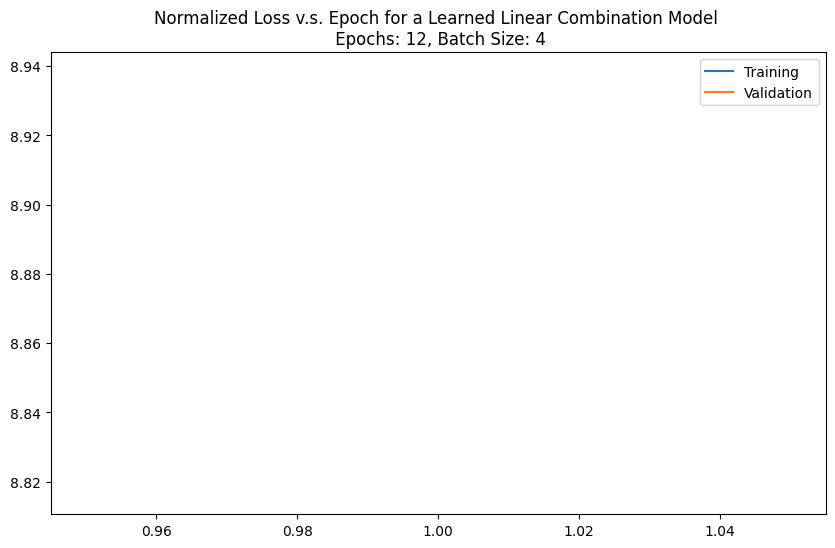

Epoch 2/12, Batch 0/9741
Batch Indices: [5322, 5323, 5324, 5325]
Loss: 9.667871475219727

Epoch 2/12, Batch 200/9741
Batch Indices: [17504, 17505, 17506, 17507]
Loss: 9.838058471679688

Epoch 2/12, Batch 400/9741
Batch Indices: [4042, 4043, 4044, 4045]
Loss: 7.349759101867676

Epoch 2/12, Batch 600/9741
Batch Indices: [9036, 9037, 9038, 9039]
Loss: 8.739099502563477

Epoch 2/12, Batch 800/9741
Batch Indices: [12950, 12951, 12952, 12953]
Loss: 9.382712364196777

Epoch 2/12, Batch 1000/9741
Batch Indices: [17310, 17311, 17312, 17313]
Loss: 9.059014320373535

Epoch 2/12, Batch 1200/9741
Batch Indices: [10306, 10307, 10308, 10309]
Loss: 8.838006973266602

Epoch 2/12, Batch 1400/9741
Batch Indices: [11938, 11939, 11940, 11941]
Loss: 8.867340087890625

Epoch 2/12, Batch 1600/9741
Batch Indices: [18024, 18025, 18026, 18027]
Loss: 8.040193557739258

Epoch 2/12, Batch 1800/9741
Batch Indices: [2470, 2471, 2472, 2473]
Loss: 9.68382740020752

Epoch 2/12, Batch 2000/9741
Batch Indices: [16048, 160

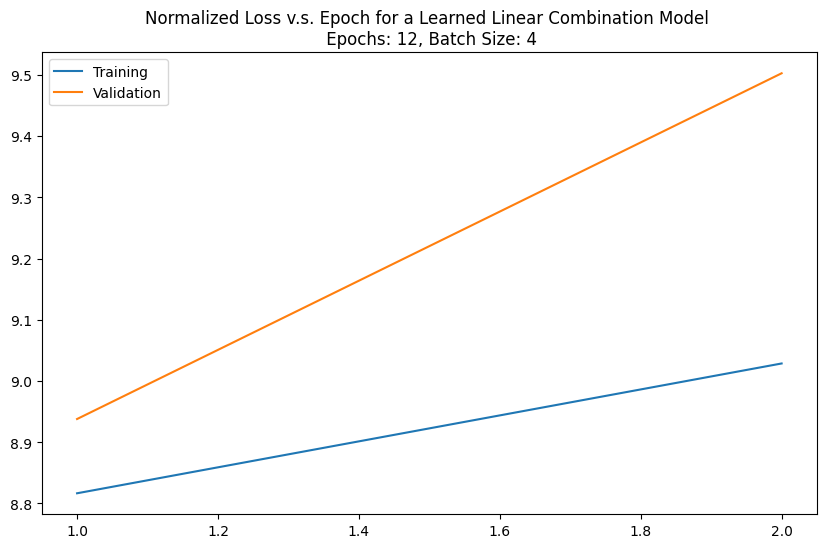

Epoch 3/12, Batch 0/9741
Batch Indices: [1674, 1675, 1676, 1677]
Loss: 8.72520637512207

Epoch 3/12, Batch 200/9741
Batch Indices: [14580, 14581, 14582, 14583]
Loss: 9.186585426330566

Epoch 3/12, Batch 400/9741
Batch Indices: [1946, 1947, 1948, 1949]
Loss: 9.061241149902344

Epoch 3/12, Batch 600/9741
Batch Indices: [12216, 12217, 12218, 12219]
Loss: 9.030768394470215

Epoch 3/12, Batch 800/9741
Batch Indices: [358, 359, 360, 361]
Loss: 8.241740226745605

Epoch 3/12, Batch 1000/9741
Batch Indices: [5726, 5727, 5728, 5729]
Loss: 9.710528373718262

Epoch 3/12, Batch 1200/9741
Batch Indices: [7638, 7639, 7640, 7641]
Loss: 9.478533744812012

Epoch 3/12, Batch 1400/9741
Batch Indices: [13832, 13833, 13834, 13835]
Loss: 9.910879135131836

Epoch 3/12, Batch 1600/9741
Batch Indices: [10380, 10381, 10382, 10383]
Loss: 8.527281761169434

Epoch 3/12, Batch 1800/9741
Batch Indices: [2352, 2353, 2354, 2355]
Loss: 9.220521926879883

Epoch 3/12, Batch 2000/9741
Batch Indices: [9490, 9491, 9492, 9493

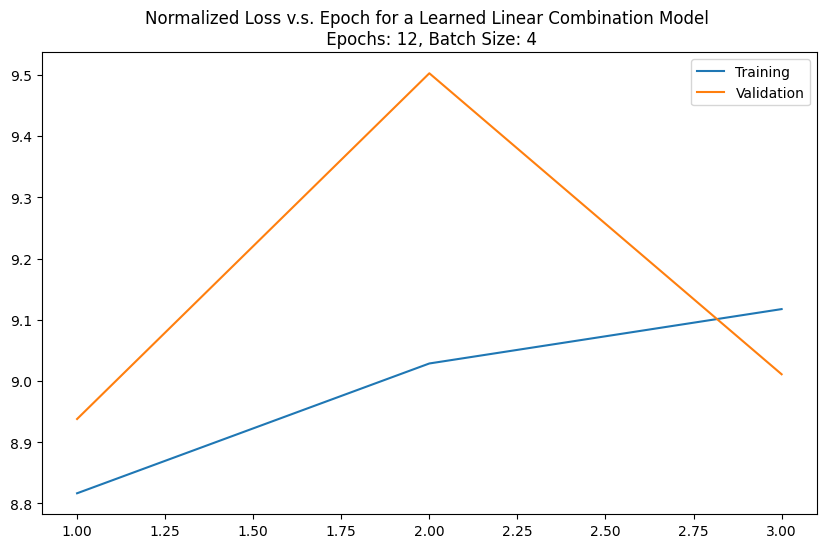

Epoch 4/12, Batch 0/9741
Batch Indices: [14074, 14075, 14076, 14077]
Loss: 8.667296409606934

Epoch 4/12, Batch 200/9741
Batch Indices: [17804, 17805, 17806, 17807]
Loss: 9.693190574645996

Epoch 4/12, Batch 400/9741
Batch Indices: [18724, 18725, 18726, 18727]
Loss: 10.175439834594727

Epoch 4/12, Batch 600/9741
Batch Indices: [18224, 18225, 18226, 18227]
Loss: 7.809377193450928

Epoch 4/12, Batch 800/9741
Batch Indices: [6262, 6263, 6264, 6265]
Loss: 8.198128700256348

Epoch 4/12, Batch 1000/9741
Batch Indices: [18328, 18329, 18330, 18331]
Loss: 10.203173637390137

Epoch 4/12, Batch 1200/9741
Batch Indices: [12582, 12583, 12584, 12585]
Loss: 8.905987739562988

Epoch 4/12, Batch 1400/9741
Batch Indices: [12434, 12435, 12436, 12437]
Loss: 9.684493064880371

Epoch 4/12, Batch 1600/9741
Batch Indices: [4050, 4051, 4052, 4053]
Loss: 7.83065938949585

Epoch 4/12, Batch 1800/9741
Batch Indices: [11374, 11375, 11376, 11377]
Loss: 9.660514831542969

Epoch 4/12, Batch 2000/9741
Batch Indices: [

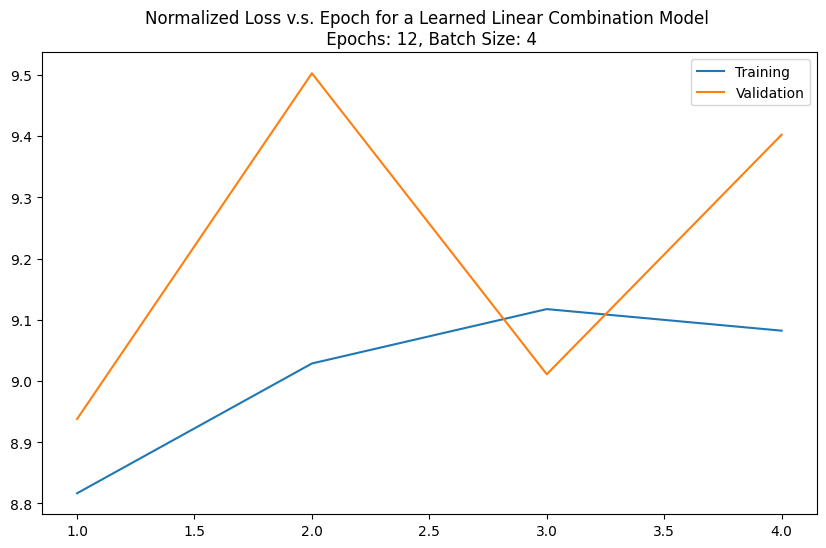

Epoch 5/12, Batch 0/9741
Batch Indices: [510, 511, 512, 513]
Loss: 8.595778465270996

Epoch 5/12, Batch 200/9741
Batch Indices: [16878, 16879, 16880, 16881]
Loss: 9.738252639770508

Epoch 5/12, Batch 400/9741
Batch Indices: [4382, 4383, 4384, 4385]
Loss: 9.968958854675293

Epoch 5/12, Batch 600/9741
Batch Indices: [6598, 6599, 6600, 6601]
Loss: 9.022798538208008

Epoch 5/12, Batch 800/9741
Batch Indices: [17014, 17015, 17016, 17017]
Loss: 7.777781009674072

Epoch 5/12, Batch 1000/9741
Batch Indices: [4604, 4605, 4606, 4607]
Loss: 9.544075012207031

Epoch 5/12, Batch 1200/9741
Batch Indices: [15902, 15903, 15904, 15905]
Loss: 8.734894752502441

Epoch 5/12, Batch 1400/9741
Batch Indices: [7614, 7615, 7616, 7617]
Loss: 10.030434608459473

Epoch 5/12, Batch 1600/9741
Batch Indices: [5190, 5191, 5192, 5193]
Loss: 8.226426124572754

Epoch 5/12, Batch 1800/9741
Batch Indices: [2252, 2253, 2254, 2255]
Loss: 8.814069747924805

Epoch 5/12, Batch 2000/9741
Batch Indices: [12986, 12987, 12988, 129

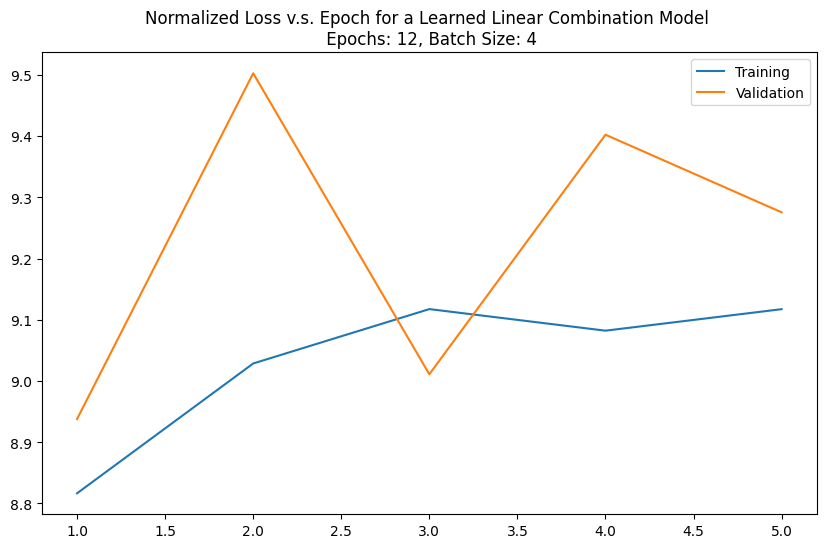

Epoch 6/12, Batch 0/9741
Batch Indices: [424, 425, 426, 427]
Loss: 9.134603500366211

Epoch 6/12, Batch 200/9741
Batch Indices: [14576, 14577, 14578, 14579]
Loss: 10.010221481323242

Epoch 6/12, Batch 400/9741
Batch Indices: [12466, 12467, 12468, 12469]
Loss: 8.809916496276855

Epoch 6/12, Batch 600/9741
Batch Indices: [9440, 9441, 9442, 9443]
Loss: 9.04758358001709

Epoch 6/12, Batch 800/9741
Batch Indices: [13642, 13643, 13644, 13645]
Loss: 9.108455657958984

Epoch 6/12, Batch 1000/9741
Batch Indices: [4930, 4931, 4932, 4933]
Loss: 8.219475746154785

Epoch 6/12, Batch 1200/9741
Batch Indices: [6092, 6093, 6094, 6095]
Loss: 9.334020614624023

Epoch 6/12, Batch 1400/9741
Batch Indices: [6836, 6837, 6838, 6839]
Loss: 9.071541786193848

Epoch 6/12, Batch 1600/9741
Batch Indices: [16216, 16217, 16218, 16219]
Loss: 7.618520259857178

Epoch 6/12, Batch 1800/9741
Batch Indices: [1290, 1291, 1292, 1293]
Loss: 9.206611633300781

Epoch 6/12, Batch 2000/9741
Batch Indices: [15702, 15703, 15704, 

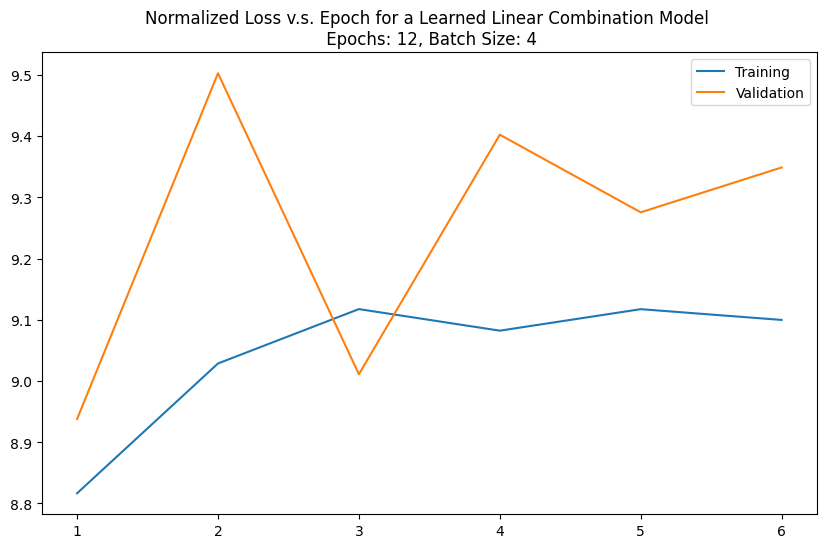

Epoch 7/12, Batch 0/9741
Batch Indices: [12916, 12917, 12918, 12919]
Loss: 9.861879348754883

Epoch 7/12, Batch 200/9741
Batch Indices: [15450, 15451, 15452, 15453]
Loss: 9.063068389892578

Epoch 7/12, Batch 400/9741
Batch Indices: [10316, 10317, 10318, 10319]
Loss: 9.416945457458496

Epoch 7/12, Batch 600/9741
Batch Indices: [5422, 5423, 5424, 5425]
Loss: 9.958151817321777

Epoch 7/12, Batch 800/9741
Batch Indices: [1722, 1723, 1724, 1725]
Loss: 9.459454536437988

Epoch 7/12, Batch 1000/9741
Batch Indices: [1220, 1221, 1222, 1223]
Loss: 9.348462104797363

Epoch 7/12, Batch 1200/9741
Batch Indices: [15478, 15479, 15480, 15481]
Loss: 8.910531044006348

Epoch 7/12, Batch 1400/9741
Batch Indices: [10360, 10361, 10362, 10363]
Loss: 10.433928489685059

Epoch 7/12, Batch 1600/9741
Batch Indices: [8818, 8819, 8820, 8821]
Loss: 9.351719856262207

Epoch 7/12, Batch 1800/9741
Batch Indices: [10466, 10467, 10468, 10469]
Loss: 9.076802253723145

Epoch 7/12, Batch 2000/9741
Batch Indices: [6332, 63

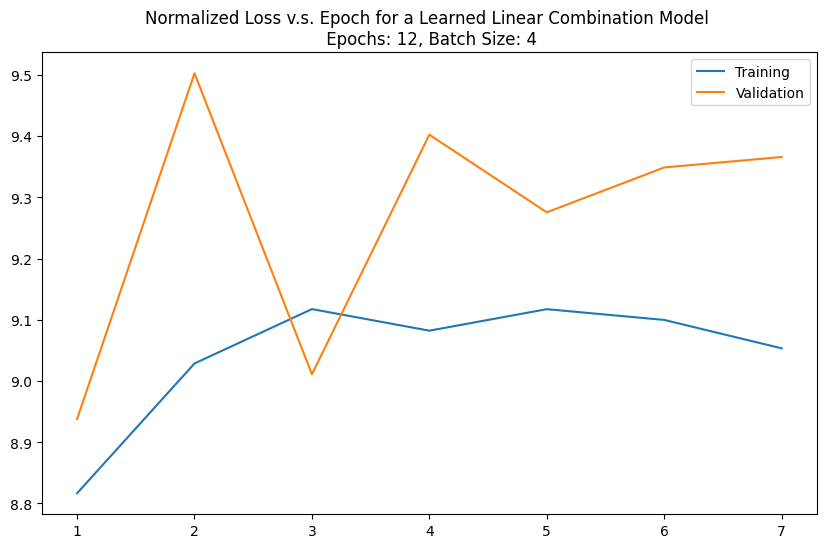

Epoch 8/12, Batch 0/9741
Batch Indices: [154, 155, 156, 157]
Loss: 9.716686248779297

Epoch 8/12, Batch 200/9741
Batch Indices: [9670, 9671, 9672, 9673]
Loss: 8.50245475769043

Epoch 8/12, Batch 400/9741
Batch Indices: [2880, 2881, 2882, 2883]
Loss: 7.864628314971924

Epoch 8/12, Batch 600/9741
Batch Indices: [11932, 11933, 11934, 11935]
Loss: 8.172713279724121

Epoch 8/12, Batch 800/9741
Batch Indices: [16572, 16573, 16574, 16575]
Loss: 8.756155967712402

Epoch 8/12, Batch 1000/9741
Batch Indices: [1434, 1435, 1436, 1437]
Loss: 8.605379104614258

Epoch 8/12, Batch 1200/9741
Batch Indices: [15656, 15657, 15658, 15659]
Loss: 8.015018463134766

Epoch 8/12, Batch 1400/9741
Batch Indices: [1432, 1433, 1434, 1435]
Loss: 9.551984786987305

Epoch 8/12, Batch 1600/9741
Batch Indices: [4600, 4601, 4602, 4603]
Loss: 10.446114540100098

Epoch 8/12, Batch 1800/9741
Batch Indices: [17910, 17911, 17912, 17913]
Loss: 9.48874282836914

Epoch 8/12, Batch 2000/9741
Batch Indices: [12302, 12303, 12304, 1

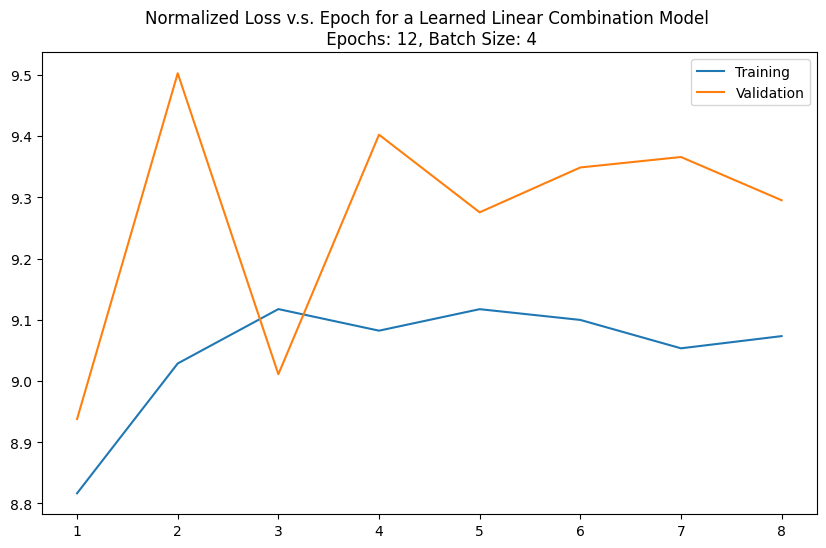

Epoch 9/12, Batch 0/9741
Batch Indices: [580, 581, 582, 583]
Loss: 9.801192283630371

Epoch 9/12, Batch 200/9741
Batch Indices: [15662, 15663, 15664, 15665]
Loss: 9.878846168518066

Epoch 9/12, Batch 400/9741
Batch Indices: [2882, 2883, 2884, 2885]
Loss: 8.395441055297852

Epoch 9/12, Batch 600/9741
Batch Indices: [13802, 13803, 13804, 13805]
Loss: 9.421144485473633

Epoch 9/12, Batch 800/9741
Batch Indices: [8302, 8303, 8304, 8305]
Loss: 9.194196701049805

Epoch 9/12, Batch 1000/9741
Batch Indices: [5510, 5511, 5512, 5513]
Loss: 8.648162841796875

Epoch 9/12, Batch 1200/9741
Batch Indices: [6812, 6813, 6814, 6815]
Loss: 8.970673561096191

Epoch 9/12, Batch 1400/9741
Batch Indices: [5178, 5179, 5180, 5181]
Loss: 8.81959342956543

Epoch 9/12, Batch 1600/9741
Batch Indices: [7398, 7399, 7400, 7401]
Loss: 8.725455284118652

Epoch 9/12, Batch 1800/9741
Batch Indices: [18966, 18967, 18968, 18969]
Loss: 9.72932243347168

Epoch 9/12, Batch 2000/9741
Batch Indices: [10760, 10761, 10762, 10763]

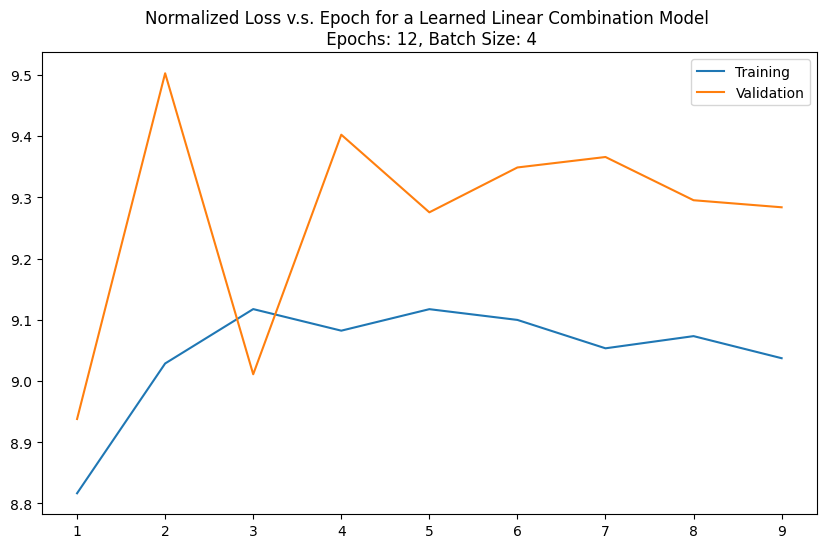

Epoch 10/12, Batch 0/9741
Batch Indices: [5782, 5783, 5784, 5785]
Loss: 8.45993423461914

Epoch 10/12, Batch 200/9741
Batch Indices: [3536, 3537, 3538, 3539]
Loss: 10.11786937713623

Epoch 10/12, Batch 400/9741
Batch Indices: [2902, 2903, 2904, 2905]
Loss: 8.43685531616211

Epoch 10/12, Batch 600/9741
Batch Indices: [18568, 18569, 18570, 18571]
Loss: 9.113083839416504

Epoch 10/12, Batch 800/9741
Batch Indices: [15114, 15115, 15116, 15117]
Loss: 8.644670486450195

Epoch 10/12, Batch 1000/9741
Batch Indices: [10634, 10635, 10636, 10637]
Loss: 8.682897567749023

Epoch 10/12, Batch 1200/9741
Batch Indices: [17058, 17059, 17060, 17061]
Loss: 8.574856758117676

Epoch 10/12, Batch 1400/9741
Batch Indices: [1354, 1355, 1356, 1357]
Loss: 8.183499336242676

Epoch 10/12, Batch 1600/9741
Batch Indices: [2684, 2685, 2686, 2687]
Loss: 9.926993370056152

Epoch 10/12, Batch 1800/9741
Batch Indices: [19332, 19333, 19334, 19335]
Loss: 9.5562744140625

Epoch 10/12, Batch 2000/9741
Batch Indices: [13432,

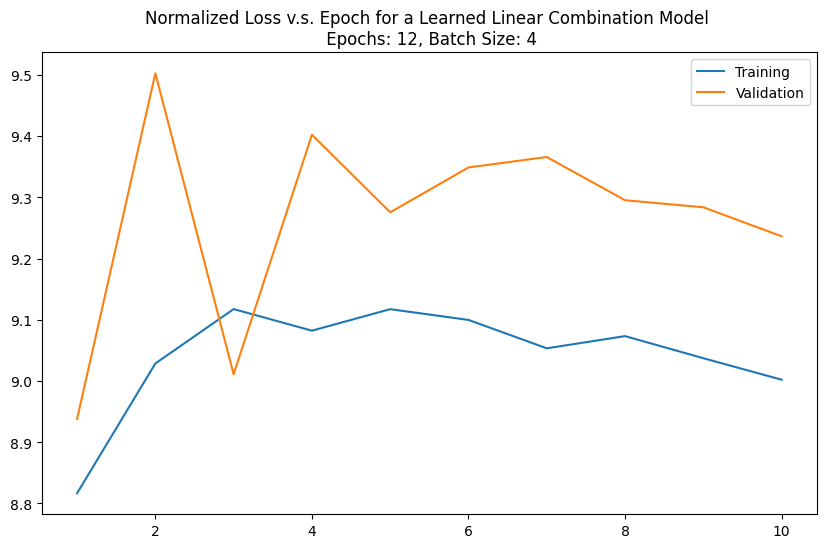

Epoch 11/12, Batch 0/9741
Batch Indices: [16502, 16503, 16504, 16505]
Loss: 9.752036094665527

Epoch 11/12, Batch 200/9741
Batch Indices: [2834, 2835, 2836, 2837]
Loss: 9.774133682250977

Epoch 11/12, Batch 400/9741
Batch Indices: [10834, 10835, 10836, 10837]
Loss: 8.45722484588623

Epoch 11/12, Batch 600/9741
Batch Indices: [11502, 11503, 11504, 11505]
Loss: 8.997716903686523

Epoch 11/12, Batch 800/9741
Batch Indices: [10832, 10833, 10834, 10835]
Loss: 8.219983100891113

Epoch 11/12, Batch 1000/9741
Batch Indices: [10874, 10875, 10876, 10877]
Loss: 10.0626220703125

Epoch 11/12, Batch 1200/9741
Batch Indices: [7104, 7105, 7106, 7107]
Loss: 8.773819923400879

Epoch 11/12, Batch 1400/9741
Batch Indices: [7184, 7185, 7186, 7187]
Loss: 8.609466552734375

Epoch 11/12, Batch 1600/9741
Batch Indices: [13962, 13963, 13964, 13965]
Loss: 10.953861236572266

Epoch 11/12, Batch 1800/9741
Batch Indices: [9782, 9783, 9784, 9785]
Loss: 8.126157760620117

Epoch 11/12, Batch 2000/9741
Batch Indices: 

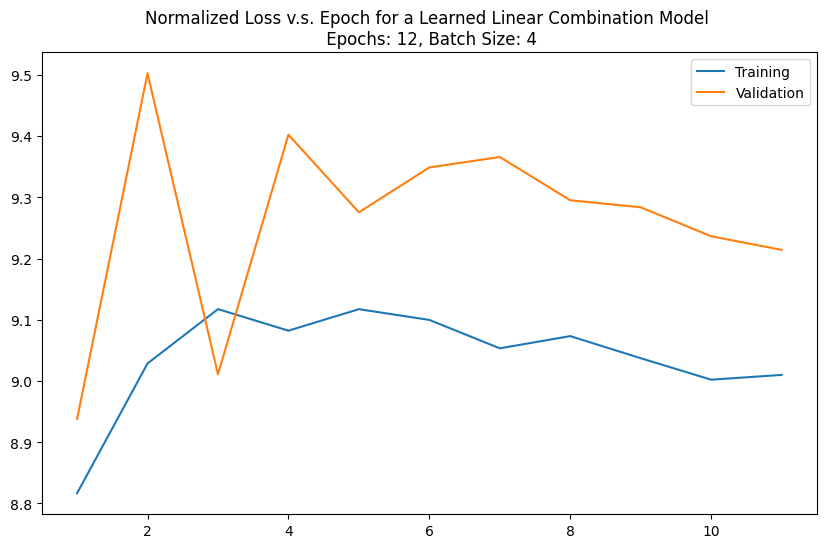

Epoch 12/12, Batch 0/9741
Batch Indices: [10338, 10339, 10340, 10341]
Loss: 8.300254821777344

Epoch 12/12, Batch 200/9741
Batch Indices: [7860, 7861, 7862, 7863]
Loss: 8.832852363586426

Epoch 12/12, Batch 400/9741
Batch Indices: [2206, 2207, 2208, 2209]
Loss: 9.659744262695312

Epoch 12/12, Batch 600/9741
Batch Indices: [7368, 7369, 7370, 7371]
Loss: 9.100993156433105

Epoch 12/12, Batch 800/9741
Batch Indices: [10798, 10799, 10800, 10801]
Loss: 8.700161933898926

Epoch 12/12, Batch 1000/9741
Batch Indices: [3430, 3431, 3432, 3433]
Loss: 9.59173583984375

Epoch 12/12, Batch 1200/9741
Batch Indices: [18754, 18755, 18756, 18757]
Loss: 8.22536849975586

Epoch 12/12, Batch 1400/9741
Batch Indices: [968, 969, 970, 971]
Loss: 9.538556098937988

Epoch 12/12, Batch 1600/9741
Batch Indices: [12824, 12825, 12826, 12827]
Loss: 10.38322925567627

Epoch 12/12, Batch 1800/9741
Batch Indices: [15584, 15585, 15586, 15587]
Loss: 8.509610176086426

Epoch 12/12, Batch 2000/9741
Batch Indices: [4690, 46

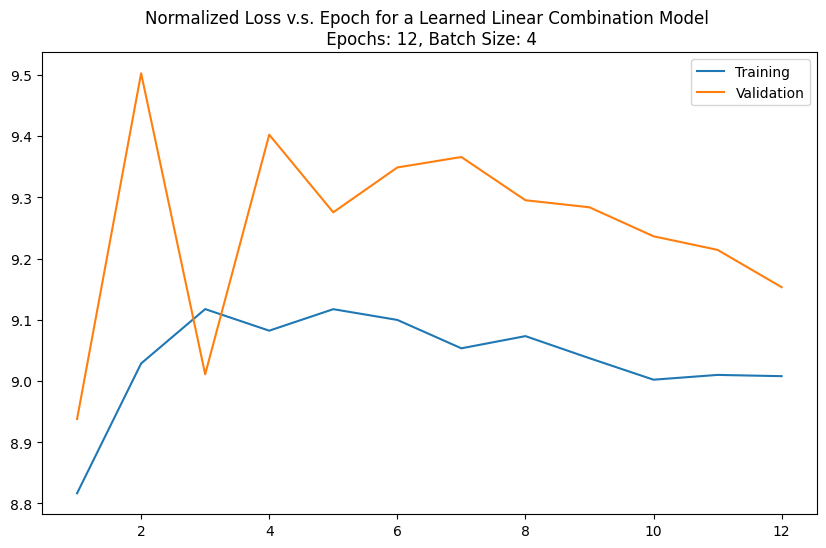

In [2]:
# Training parameters
epochs = 12
batch_size = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Training...')

# Training loop
projected_losses = []
validation_losses = []

shapes = []

for epoch in range(epochs):
    epoch_loss_continuous = 0
    epoch_loss_projected = 0
    epoch_loss_validation = 0
    for _ in range(0, len(train_dataset), batch_size):
        i = random.randint(0, len(train_dataset) - batch_size + 1 )
        batch = train_dataset[i:i+batch_size]
        if len(batch['inputs_pretokenized']) != batch_size:
          continue
        input_ids = tokenizer(batch['inputs_pretokenized'], return_tensors='pt', padding=True, truncation=True).input_ids.to(device)
        labels = tokenizer(batch['targets_pretokenized'], return_tensors='pt', padding=True, truncation=True).input_ids.to(device)

        # Get the prompt input embeddings - same if continuous or projected
        input_embeddings = model_projected.model.shared(input_ids)
        padding_size = max(0, 100 - input_embeddings.shape[1])
        input_embeddings = F.pad(input_embeddings, (0, 0, 0, padding_size), "constant", 0)
        input_embeddings_projected = torch.Tensor(input_embeddings).to(device)


        weights = learn_weights(input_embeddings)
        # print(f'predicted weights' + str(weights))
        # print(f'predicted weights shape' + str(weights.shape))
        # print(f'basis shape' + str(basis.shape))
        # print(f'input embeddings shape' + str(input_embeddings.shape))
        # print(f'soft prompt shape' + str(soft_prompt.shape))
        # print(f'soft prompt batch shape' + str(soft_prompt_batch.shape))
        projected_prompt_batch = weights.unsqueeze(1).unsqueeze(2).expand_as(basis) * basis
        projected_prompt_batch = projected_prompt_batch.sum(dim=0).unsqueeze(0).repeat(batch_size, 1, 1).to(device)
        # print(f'projected prompt batch shape' + str(projected_prompt_batch.shape))
        # print(f'shapes of soft batch and input embeddings: {soft_prompt_batch.shape}, {input_embeddings.shape}')


        combined_projected_embeddings = torch.cat([projected_prompt_batch, input_embeddings_projected], dim=1)

        # Pass the combined embeddings through the model
        outputs_projected = model_projected(inputs_embeds=combined_projected_embeddings, labels=labels)

        loss_projected = outputs_projected.loss
        epoch_loss_projected += loss_projected.item()

        optimizer_projected.zero_grad()
        loss_projected.backward(retain_graph=True)
        optimizer_projected.step()

        #print(f'complete from this epoch {i}/{len(train_dataset)}', end='')
        if _ % 200 == 0:
          print(f'Epoch {epoch+1}/{epochs}, Batch {_}/{len(train_dataset)}')
          print(f'Batch Indices: {[i + k for k in range(i, i+batch_size)]}')
          print(f'Loss: {loss_projected.item()}')
          print()

    print('Validating Epoch...')

    for _ in range(0, len(validation_dataset), batch_size):
        i = random.randint(0, len(validation_dataset) - batch_size + 1 )
        batch = validation_dataset[i:i+batch_size]
        if len(batch['inputs_pretokenized']) != batch_size:
          continue
        input_ids = tokenizer(batch['inputs_pretokenized'], return_tensors='pt', padding=True, truncation=True).input_ids.to(device)
        labels = tokenizer(batch['targets_pretokenized'], return_tensors='pt', padding=True, truncation=True).input_ids.to(device)

        # Get the prompt input embeddings - same if continuous or projected
        input_embeddings = model_projected.model.shared(input_ids)
        padding_size = max(0, 100 - input_embeddings.shape[1])
        input_embeddings = F.pad(input_embeddings, (0, 0, 0, padding_size), "constant", 0)
        input_embeddings_projected = torch.Tensor(input_embeddings).to(device)

        weights = learn_weights(input_embeddings)
        # print(f'predicted weights' + str(weights))
        # print(f'predicted weights shape' + str(weights.shape))
        # print(f'basis shape' + str(basis.shape))
        # print(f'input embeddings shape' + str(input_embeddings.shape))
        # print(f'soft prompt shape' + str(soft_prompt.shape))
        # print(f'soft prompt batch shape' + str(soft_prompt_batch.shape))
        projected_prompt_batch = weights.unsqueeze(1).unsqueeze(2).expand_as(basis) * basis
        projected_prompt_batch = projected_prompt_batch.sum(dim=0).unsqueeze(0).repeat(batch_size, 1, 1).to(device)
        # print(f'projected prompt batch shape' + str(projected_prompt_batch.shape))
        # print(f'shapes of soft batch and input embeddings: {soft_prompt_batch.shape}, {input_embeddings.shape}')

        combined_projected_embeddings = torch.cat([projected_prompt_batch, input_embeddings_projected], dim=1)
        outputs_projected = model_projected(inputs_embeds=combined_projected_embeddings, labels=labels)

        loss_validation = outputs_projected.loss
        epoch_loss_validation += loss_validation.item()

    epoch_loss_projected /= (len(list(range(0, len(train_dataset), batch_size))))
    epoch_loss_validation /= (len(list(range(0, len(validation_dataset), batch_size))) - 1)

    print(f'Epoch Validation Loss: {epoch_loss_validation} \n', end='')
    print()

    projected_losses.append(epoch_loss_projected)
    validation_losses.append(epoch_loss_validation)

    # Create a DataFrame with the loss values
    n = len(projected_losses)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n + 1), projected_losses, label='Training')
    plt.plot(range(1, n + 1), validation_losses, label='Validation')
    plt.title(f'Normalized Loss v.s. Epoch for a Learned Linear Combination Model \n Epochs: {epochs}, Batch Size: {batch_size}')
    plt.legend()

    # Save the plot as a png file
    print(f'Saveing figure...')
    plt.savefig(f'loss_plot_epoch_{epoch+1}.png')
    plt.show()
